In [1]:
import pycbc.noise
import pycbc.psd
import pycbc.filter
import pylab
from pycbc.filter import sigma
from pycbc.waveform import get_td_waveform
from pycbc.psd import interpolate

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


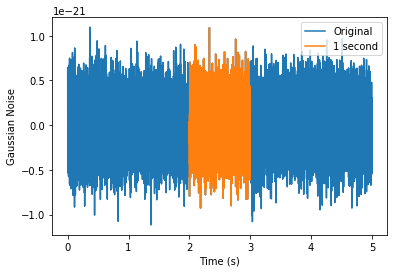

In [2]:
# Generate psd
flow = 20.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate 5 seconds of noise at 4096 Hz
delta_t = 1.0 / 4096
tsamples = int(5 / delta_t)
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)
pylab.plot(ts.sample_times, ts, label='Original')

#Suppress the high frequencies
#ts = pycbc.filter.lowpass_fir(ts, 1000.0, 8)
#pylab.plot(ts.sample_times, ts, label='Lowpassed < 1000 hz')

# crop to 1 second
ts=ts.crop(2,2)

pylab.plot(ts.sample_times, ts, label='1 second')

pylab.legend()
pylab.ylabel('Gaussian Noise')
pylab.xlabel('Time (s)')
pylab.show()

Uncertain parts:
- flen in psd is generated in a very specific way.
- unsure about psd in general
- should I supress high frequencies? also I specified order 8 but don't know what that really means. If I choose to apply low-pass filters, need to crop ends, which are corrupt by filter
    - tried supress high frequencies. Doesn't seem to be preferrable at a glance

In [3]:
# CHECK: delta_t, delta_f, which need to match with merger waveform later
# print out sample frequency
print("delta_t: ", psd.delta_t, ts.delta_t)
print("delta_f: ", psd.delta_f, ts.delta_f)
print("what merger waveform need to be resized to: ", ts.shape)

delta_t:  0.000244140625 0.000244140625
delta_f:  0.0625 1.0
what merger waveform need to be resized to:  (4096,)


As shown, somehow, delta_f of noise becomes 1hz as long as the length of noise is 1 second, changing other parameters does not help. If necessary, can use the following to make the delta_f to 0.1 hz as desired, but maybe it won't be helpful because it is not downsizing the data.
- pycbc.filter.resample.interpolate_complex_frequency(series, delta_f, zeros_offset=0, side='right')

-0.84844589
-0.426172797


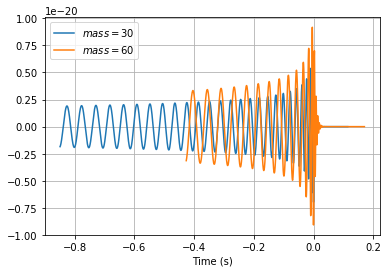

In [68]:
# Consider waveforms


for m1 in [30]: 
    for m2 in [30,60]: 
        hp,hc=get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m1,    
                             mass2=m2,
                             delta_t=1.0/4096,
                             f_lower=20,
                             distance=100)
        pylab.plot(hp.sample_times, hp, label='$mass=%s$'%m2) 
        print(hp.start_time)
# plot
pylab.xlabel("Time (s)")
pylab.legend()
pylab.grid()
pylab.show()

As shown, in order for the waveform signal to be 2s, so that at least half of the signal can be contained in the window of 1 second. We should look at this range for each mass >19 (since 19,19 gives around 2 seconds.)

Since 99% blackhole mergers have below 45 solar masses, the upperbound would be around 50.

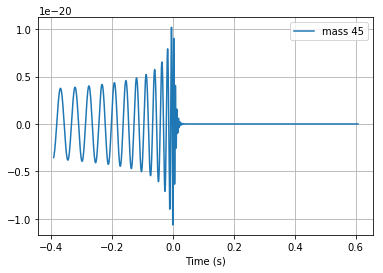

In [5]:
# Generate one waveform to be imbedded:

m = 45
hp,hc=get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m,    
                             mass2=m,
                             delta_t=1.0/4096,
                             f_lower=20,
                             distance=100)

# resize to window of 1 second
hp.resize(4096)

# plot
pylab.plot(hp.sample_times, hp, label='mass 45')
pylab.xlabel("Time (s)")
pylab.legend()
pylab.grid()
pylab.show()

In [6]:
# look at the loudness of noise and of waveform
print('loudness of waveform:', sigma(hp))
print('loudness of noise:', sigma(ts))

# look at the peak signal near merger
peak = abs(hp).numpy().argmax()
snrp = hp[peak]
print('max signal:', abs(snrp))

loudness of waveform: 3.204102231004819e-21
loudness of noise: 3.83657699245129e-22
max signal: 1.0658693388340552e-20


Confusion: when we specify snr 1000, are we indicating sigma or the maximum signal?
seems like sigma is the mean loudness

In [26]:
# Check the SNR of signal 
# First interpolate psd to desire delta_f
new_psd = pycbc.psd.estimate.interpolate(psd, hp.delta_f)

# compute signal to unscaled noise ratio
snr = sigma(hp, psd=new_psd, low_frequency_cutoff=20.0)

# compute scaling factor
goal_snr = 1000
c = snr/goal_snr

print("The SNR of signal is: ", snr, ", indicating noise should be scaled by", c)

# Scale the noise
scaled_ts = c * ts

The SNR of signal is:  513.1601266453514 , indicating noise should be scaled by 0.5131601266453514


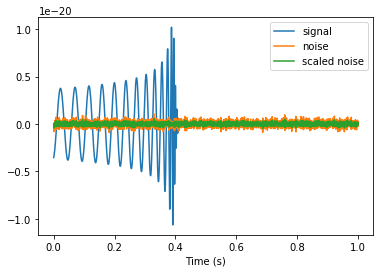

In [20]:
# Set both start time to zero for imbedding 
hp.start_time = 0
ts.start_time = 0
scaled_ts.start_time = 0

# plot signal and noise before 
pylab.plot(hp.sample_times, hp, label='signal')
pylab.plot(ts.sample_times, ts, label='noise')
pylab.plot(ts.sample_times, scaled_ts, label='scaled noise')
pylab.xlabel("Time (s)")
pylab.legend()
pylab.show()

noise seems to be too weak. Not sure if we want that

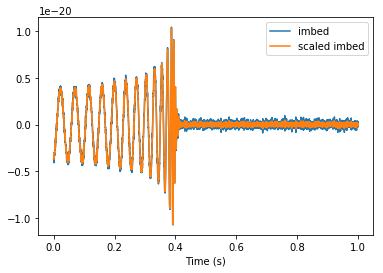

In [21]:
# imbed signal in original noise
imbed = ts + hp

# imbed signal in scaled noise
scaled_imbed = scaled_ts + hp

# plot signal and noise before 
pylab.plot(imbed.sample_times, imbed, label='imbed')
pylab.plot(scaled_imbed.sample_times, scaled_imbed, label='scaled imbed')
pylab.xlabel("Time (s)")
pylab.legend()
pylab.show()

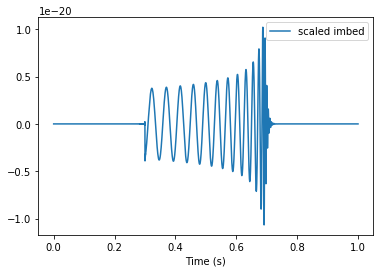

In [22]:
# shift the waveform and merge
shifted = hp.cyclic_time_shift(0.3)

shifted.start_time = 0

pylab.plot(shifted.sample_times, shifted, label='scaled imbed')
pylab.xlabel("Time (s)")
pylab.legend()
pylab.show()

Cyclic time shift could divide and separate the waveform in two parts, which would be undesirable. So need to come up with an algorithm to compute out the signal range, and guarentee at least half of the signal is remained in the 1 second window. Also avoid cutting up waveform. need to find how to do roll time shift

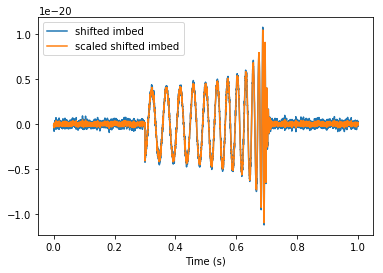

In [23]:
# imbed the shifted signal
# in original noise and in scaled
shifted_imbed = ts + shifted
scaled_shifted_imbed = scaled_ts + shifted

# plot signal and noise before 
pylab.plot(shifted_imbed.sample_times, shifted_imbed, label='shifted imbed')
pylab.plot(scaled_shifted_imbed.sample_times, scaled_shifted_imbed, label='scaled shifted imbed')
pylab.xlabel("Time (s)")
pylab.legend()
pylab.show()

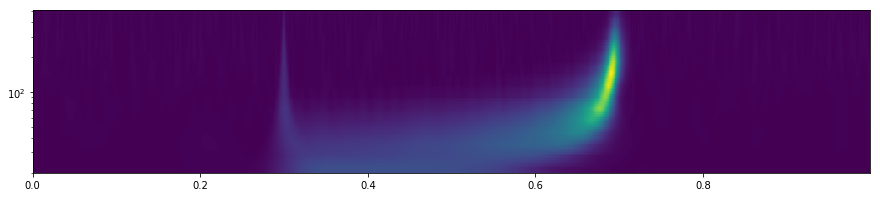

In [24]:
# Visualize the GW signal to check
               
# The qtransform method returns a vector of the sample times, frequencies, and a 2-d vector of the 
# power in each time-frequency bin. The free parameter is the choice of the Q-value. Larger Q-values
# are generally more appropriate for viewing long duration features of the data and vice versa. 
                    
# The options here:
# (1) The time spacing for the output image (i.e. 1 ms in this case)
# (2) The number of frequency bins in the output, logarithmically spaced
# (3) The qrange to maximize over. We'll pick a constant at 8 here
#     Typically higher values will be more appropriate for longer duration
#     signals
# (4) The frequency range to output
times, freqs, power = shifted_imbed.qtransform(.001, logfsteps=100,
                                                qrange=(4, 4),
                                                frange=(20, 512),)
pylab.figure(figsize=[15, 3])
pylab.pcolormesh(times, freqs, power**0.5)
pylab.yscale('log')
pylab.show()

Code for visualization from: https://pycbc.org/tutorials/2/2_VisualizationSignalProcessing/
In the tutorial, the method for GW detection is: 
- high pass (remove low freq contents)
- Whitening takes the data and attempts to make the power spectral density flat
- bandpass the result to focus on a specific frequency range.
- A common way to visualize gravitational-wave data is with a time-frequency representation known as the constant-Q transform. It is similar to a standard spectrogram made with short-time Fourier transforms with the advantage that frequency bins are more sparsely spaced at high freqeuncys.

The signal pretty prominent for low noise. We use matched-filtering for more noise background.

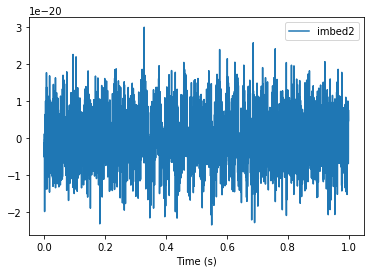

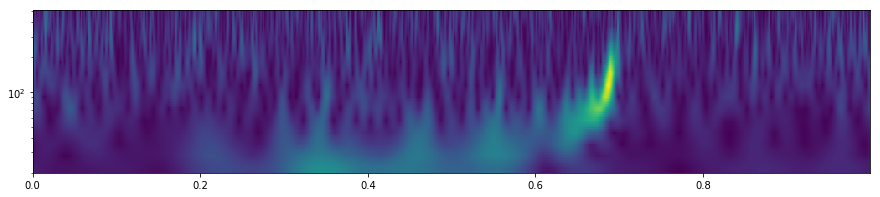

signal to noise ratio: 1.1112711575252847


In [25]:
# Scale more to check if the signal still recognisable on the spectrogram.

imbed2 = 25*ts + shifted

# plot signal and noise before 
pylab.plot(imbed2.sample_times, imbed2, label='imbed2')
pylab.xlabel("Time (s)")
pylab.legend()
pylab.show()

# spectrogram
times, freqs, power = imbed2.qtransform(.001, logfsteps=100,
                                                qrange=(4, 4),
                                                frange=(20, 512),)
pylab.figure(figsize=[15, 3])
pylab.pcolormesh(times, freqs, power**0.5)
pylab.yscale('log')
pylab.show()

print("signal to noise ratio:", abs(snrp)/sigma(25*ts))

I think if the signal is recognisable on spectrogram, it should be machine learnable, so should I consider varying the SNR? since we also don't have enough templates. This can help generate more training data.